In [2]:
import json
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [3]:
import gensim.downloader as api
from gensim.models import KeyedVectors
# Load fastText and GloVe models
fasttext_model = api.load('fasttext-wiki-news-subwords-300')
glove_model = api.load('glove-wiki-gigaword-300')
# Path to the extracted vectors file using raw string literal
file_path = r"C:\Users\hp\OneDrive\Desktop\Pre-trained\GoogleNews-vectors-negative300.bin"
# Load the Word2Vec model
Word2Vec_model = KeyedVectors.load_word2vec_format(file_path, binary=True)

In [4]:
models = {
    'fastText': fasttext_model,
    'GloVe': glove_model,
    'Word2Vec': Word2Vec_model
}

In [5]:
# Function to encode tokens using the provided model
def encode_tokens(tokens, model):
    token_embeddings = []
    for token in tokens:
        if token in model:
            token_embeddings.append(model[token])
    return np.mean(token_embeddings, axis=0) if token_embeddings else None

# Function to encode documents for a particular class using the provided model
def encode_documents(class_data, model):
    encoded_docs = {}
    for doc_id, tokens in class_data.items():
        doc_embedding = encode_tokens(tokens, model)
        if doc_embedding is not None:
            encoded_docs[doc_id] = doc_embedding
    return encoded_docs

# Function to encode the entire preprocessed data using the provided models
def encode_data(preprocessed_data, models):
    encoded_data = {}
    for model_name, model in models.items():
        encoded_data[model_name] = {}
        for class_name, class_docs in preprocessed_data.items():
            class_embeddings = {}
            encoded_docs = encode_documents(class_docs, model)
            class_embeddings = encoded_docs
            encoded_data[model_name][class_name] = class_embeddings
    return encoded_data

In [6]:
with open('preprocessed_train_data.json', 'r', encoding='utf-8') as train_file:
    preprocessed_train_data = json.load(train_file)

with open('preprocessed_test_data.json', 'r', encoding='utf-8') as test_file:
    preprocessed_test_data = json.load(test_file)

In [7]:
encoded_train_data = encode_data(preprocessed_train_data, models)

# Encode testing data
encoded_test_data = encode_data(preprocessed_test_data, models)

In [8]:
print("Sample embedding vector:")
print(encoded_train_data['fastText']['acq']['0000005'])

Sample embedding vector:
[ 3.91601538e-03  1.10584690e-04  6.05732948e-03 -3.97716911e-04
  3.45182745e-03 -9.12356377e-03 -2.60397210e-03 -8.95496979e-02
  6.35943841e-03 -1.73813999e-02 -2.35437565e-02 -3.43406536e-02
  1.46725187e-02  3.15204915e-03 -1.65409991e-03  1.43167027e-03
  6.73393384e-02 -9.92863253e-03  7.40821213e-02  3.54365399e-03
 -4.90829116e-03  3.46694491e-03 -1.37697542e-02  5.57641983e-02
  5.30316494e-03 -5.93636977e-03 -7.00745219e-03  3.12555837e-03
  1.35122547e-02 -1.73095439e-04  4.63185413e-03  2.17584576e-02
 -1.18068075e-02 -2.84062456e-02  9.15256049e-03 -6.62902137e-03
  7.16503244e-03  2.20816117e-02  5.82688022e-03  5.27892308e-03
 -1.82043519e-02 -5.38749024e-02 -2.04512421e-02 -1.42084723e-02
 -5.04788291e-03  1.35377944e-02  6.72591198e-03 -2.16277922e-03
  1.86686907e-02  9.02599934e-03  2.61290511e-03 -5.43707842e-03
 -3.44953034e-03 -1.93107054e-02 -6.85288683e-02  1.16297016e-02
  7.82386772e-03  5.57938498e-03 -5.57214171e-02 -7.63779460e-03


In [9]:
# Function to flatten the encoded data for training
def flatten_encoded_data(encoded_data):
    X = []
    y = []
    for model_name, model_data in encoded_data.items():
        for class_name, class_docs in model_data.items():
            for doc_id, embedding in class_docs.items():
                X.append(embedding)
                y.append(class_name)
    return X, y

In [10]:
def train_classifiers(encoded_train_data, encoded_test_data):
    accuracy_scores = []
    f1_macro_scores = []

    for model_name, model_data in encoded_train_data.items():
        print("**********************")
        print("Training classifiers for", model_name)

        X_train, y_train = flatten_encoded_data({model_name: model_data})
        X_test, y_test = flatten_encoded_data({model_name: encoded_test_data[model_name]})
        
        # Label encoding
        label_encoder = LabelEncoder()
        y_train_encoded = label_encoder.fit_transform(y_train)
        y_test_encoded = label_encoder.transform(y_test)

        nb_classifier = GaussianNB()
        nb_classifier.fit(X_train, y_train_encoded)

        svm_classifier = SVC(kernel='rbf')
        svm_classifier.fit(X_train, y_train_encoded)

        rf_classifier = RandomForestClassifier()
        rf_classifier.fit(X_train, y_train_encoded)

        classifiers = {
            'Gaussian Naïve Bayes': nb_classifier,
            'SVM kernel RBF': svm_classifier,
            'Random Forest': rf_classifier
        }

        model_accuracy_scores = []
        model_f1_macro_scores = []

        for clf_name, clf in classifiers.items():
            y_pred_encoded = clf.predict(X_test)
            accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
            model_accuracy_scores.append(accuracy)
            f1_macro = f1_score(y_test_encoded, y_pred_encoded, average='macro')
            model_f1_macro_scores.append(f1_macro)

            print(clf_name, "Accuracy for", model_name, ":", accuracy)
            print(clf_name, "F1 Macro Score for", model_name, ":", f1_macro)

            # Inverse transforming predicted labels to original class names
            y_pred = label_encoder.inverse_transform(y_pred_encoded)
            print(clf_name, "Predicted Classes for", model_name, ":", y_pred)

        accuracy_scores.append(model_accuracy_scores)
        f1_macro_scores.append(model_f1_macro_scores)

    return accuracy_scores, f1_macro_scores

In [13]:
def plot_results(accuracy_scores, f1_macro_scores, model_names):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    for i, model_name in enumerate(model_names):
        plt.plot(['Gaussian NB', 'SVM', 'Random Forest'], accuracy_scores[i], label=model_name)
    plt.title('Accuracy for Different Models')
    plt.xlabel('Classifier')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    for i, model_name in enumerate(model_names):
        plt.plot(['Gaussian NB', 'SVM', 'Random Forest'], f1_macro_scores[i], label=model_name)
    plt.title('Macro-averaged F1 Score for Different Models')
    plt.xlabel('Classifier')
    plt.ylabel('F1 Macro Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

**********************
Training classifiers for fastText
Gaussian Naïve Bayes Accuracy for fastText : 0.5506958250497018
Gaussian Naïve Bayes F1 Macro Score for fastText : 0.2148970040205456
Gaussian Naïve Bayes Predicted Classes for fastText : ['trade' 'strategic-metal' 'unknown' ... 'zinc' 'copper' 'gold']
SVM kernel RBF Accuracy for fastText : 0.6734592445328031
SVM kernel RBF F1 Macro Score for fastText : 0.11877248710690838
SVM kernel RBF Predicted Classes for fastText : ['acq' 'unknown' 'acq' ... 'gold' 'copper' 'gold']
Random Forest Accuracy for fastText : 0.6381709741550696
Random Forest F1 Macro Score for fastText : 0.15374723569133522
Random Forest Predicted Classes for fastText : ['unknown' 'unknown' 'acq' ... 'acq' 'acq' 'gold']
**********************
Training classifiers for GloVe
Gaussian Naïve Bayes Accuracy for GloVe : 0.5964214711729622
Gaussian Naïve Bayes F1 Macro Score for GloVe : 0.2476662425222226
Gaussian Naïve Bayes Predicted Classes for GloVe : ['yen' 'gold' 'g

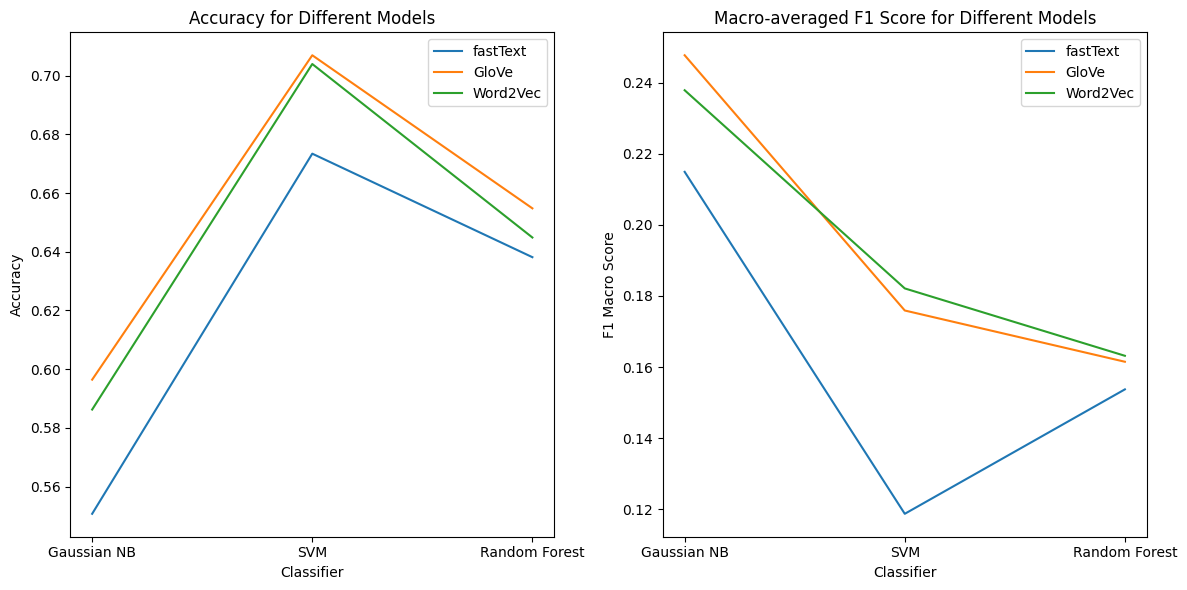

In [14]:
accuracy_scores, f1_macro_scores = train_classifiers(encoded_train_data, encoded_test_data)
plot_results(accuracy_scores, f1_macro_scores, encoded_train_data.keys())